# Kỹ thuật tăng cường tương phản ảnh
Trong phần này cần thực hiện
- Cân bằng histogram (histogram equalization)
- Cân bằng động histogram (dynamic histogram equalization)
- Một thuật toán mới tăng cường tương phản ảnh sử dụng framework Exposure Fusio

# Ảnh thực hành

In [16]:
import cv2
import matplotlib.pyplot as plt
import os

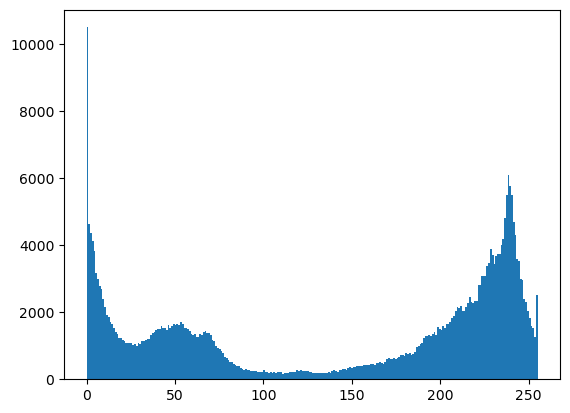

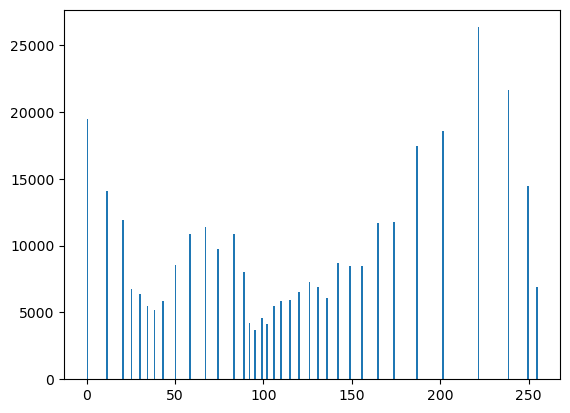

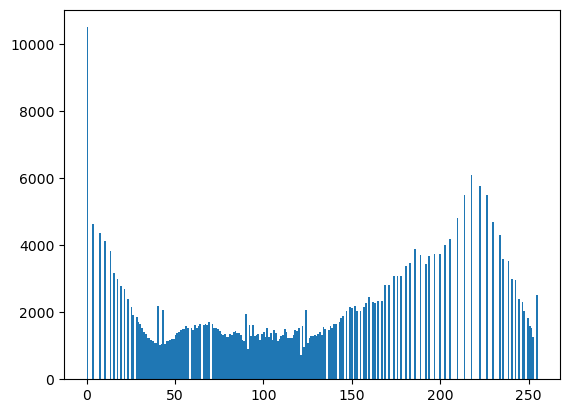

In [64]:
import numpy as np

img = cv2.imread('testdata/z02.jpg')

gray = img[:,:,0]
occ = np.zeros(256, dtype=np.uint32)
for x in gray:
    occ[x] += 1
plt.hist(gray.ravel(),bins=256)
plt.show()

cdf = []
crr = 0
for i in range(256):
    crr += occ[i]
    cdf.append(crr)

ngray = gray.copy()
for i in range(gray.shape[0]):
    for j in range(gray.shape[1]):
        ngray[i][j] = round((cdf[ngray[i][j]] - cdf[0]) / (gray.shape[0] * gray.shape[1] - cdf[0]) * 255)

plt.hist(cv2.equalizeHist(ngray.ravel()),bins=256)
plt.show()
plt.hist(cv2.equalizeHist(gray.ravel()),bins=256)
plt.show()

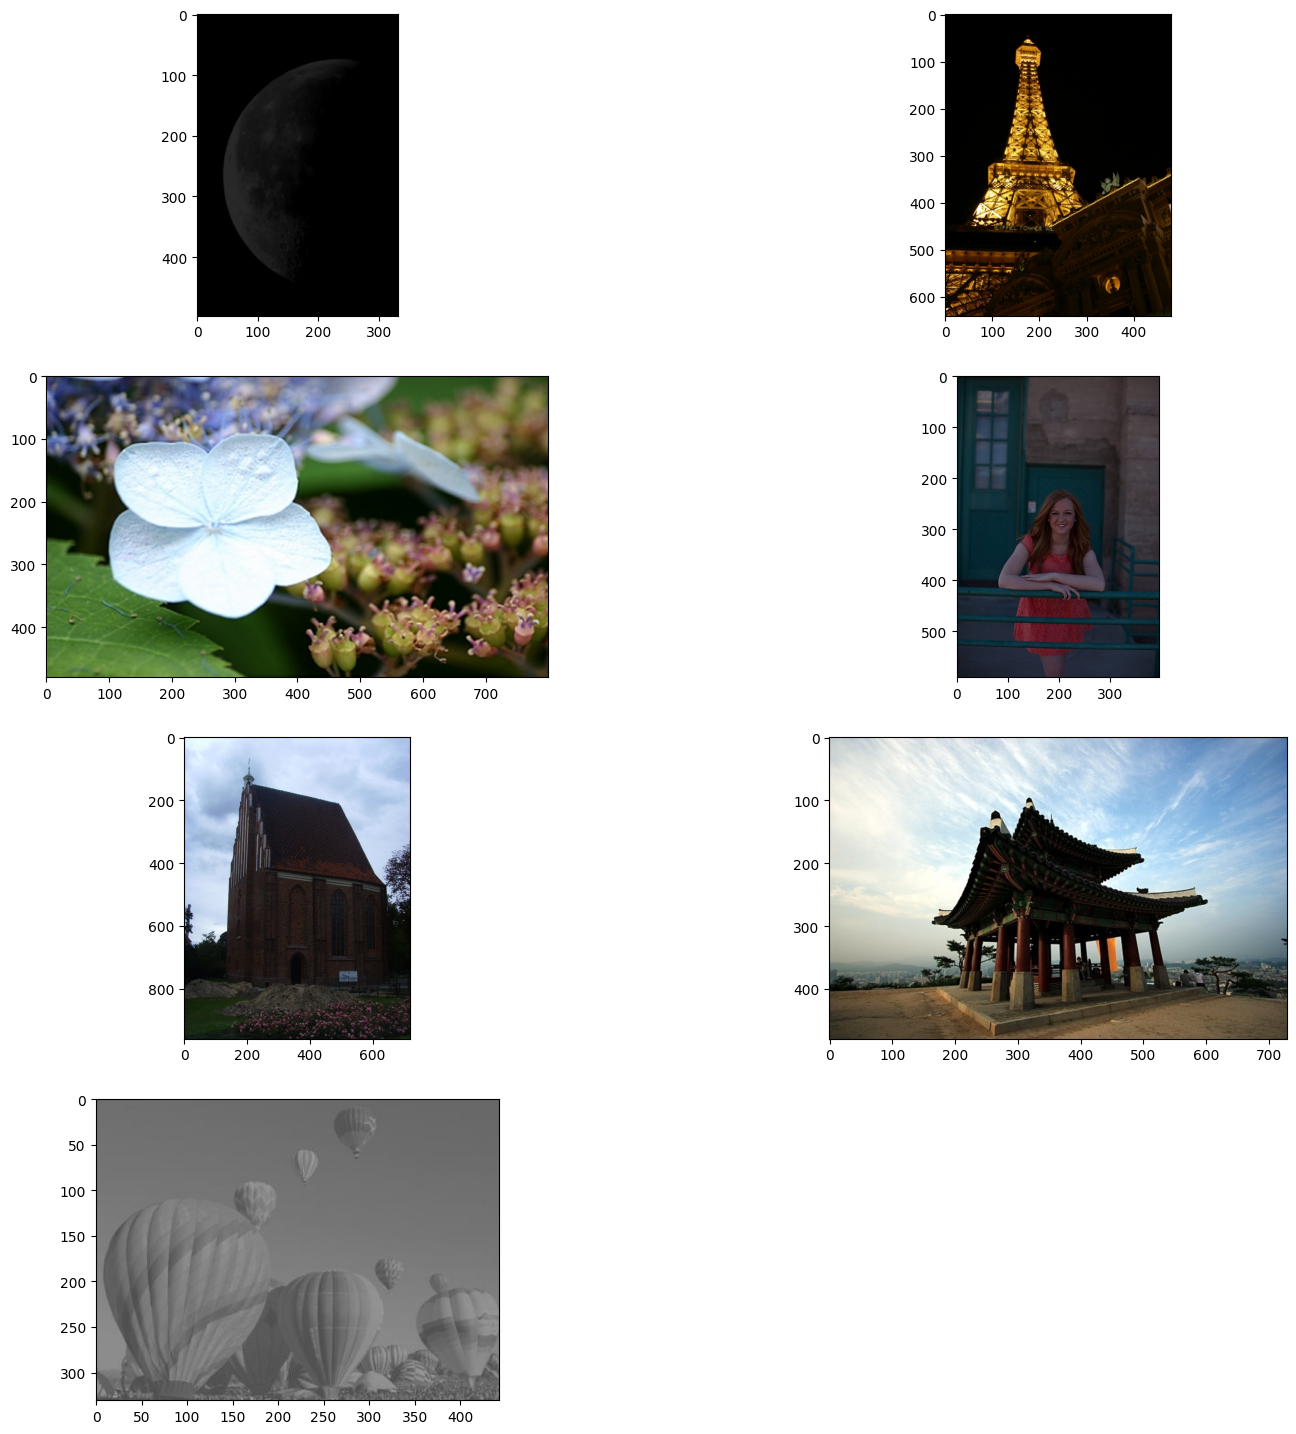

In [ ]:
img_names = os.listdir('testdata/')
plt.figure(figsize=(18, 18)) 
for i, img_name in enumerate(img_names):
    img = cv2.imread(os.path.join('testdata/', img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # for showing purpose
    plt.subplot(4,2,i+1)
    plt.imshow(img)
plt.show()

# Cân bằng Histogram

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# Yêu cầu
Hoàn thiện hàm he với trường hợp ảnh đầu vào là ảnh màu

In [9]:
def he(img):
    # if input image is gray image
    if (len(img.shape)==2):
        outImg = cv2.equalizeHist(img)
    
    # if input image is color image
    else:
        outImg = img
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        for i in range(img.shape[2]):
            outImg[:,:,i] = clahe.apply(img[:,:,i])
        # yuv_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        # yuv_img[:,:,0] = cv2.equalizeHist(yuv_img[:,:,0])
        # outImg = cv2.cvtColor(yuv_img, cv2.COLOR_YUV2RGB)

    return outImg

# Yêu cầu
- Lấy danh sách tên ảnh trong folder testdata
- Loop qua từng ảnh, đọc ảnh và truyền vào hàm he
- Hiển thị ảnh kết quả

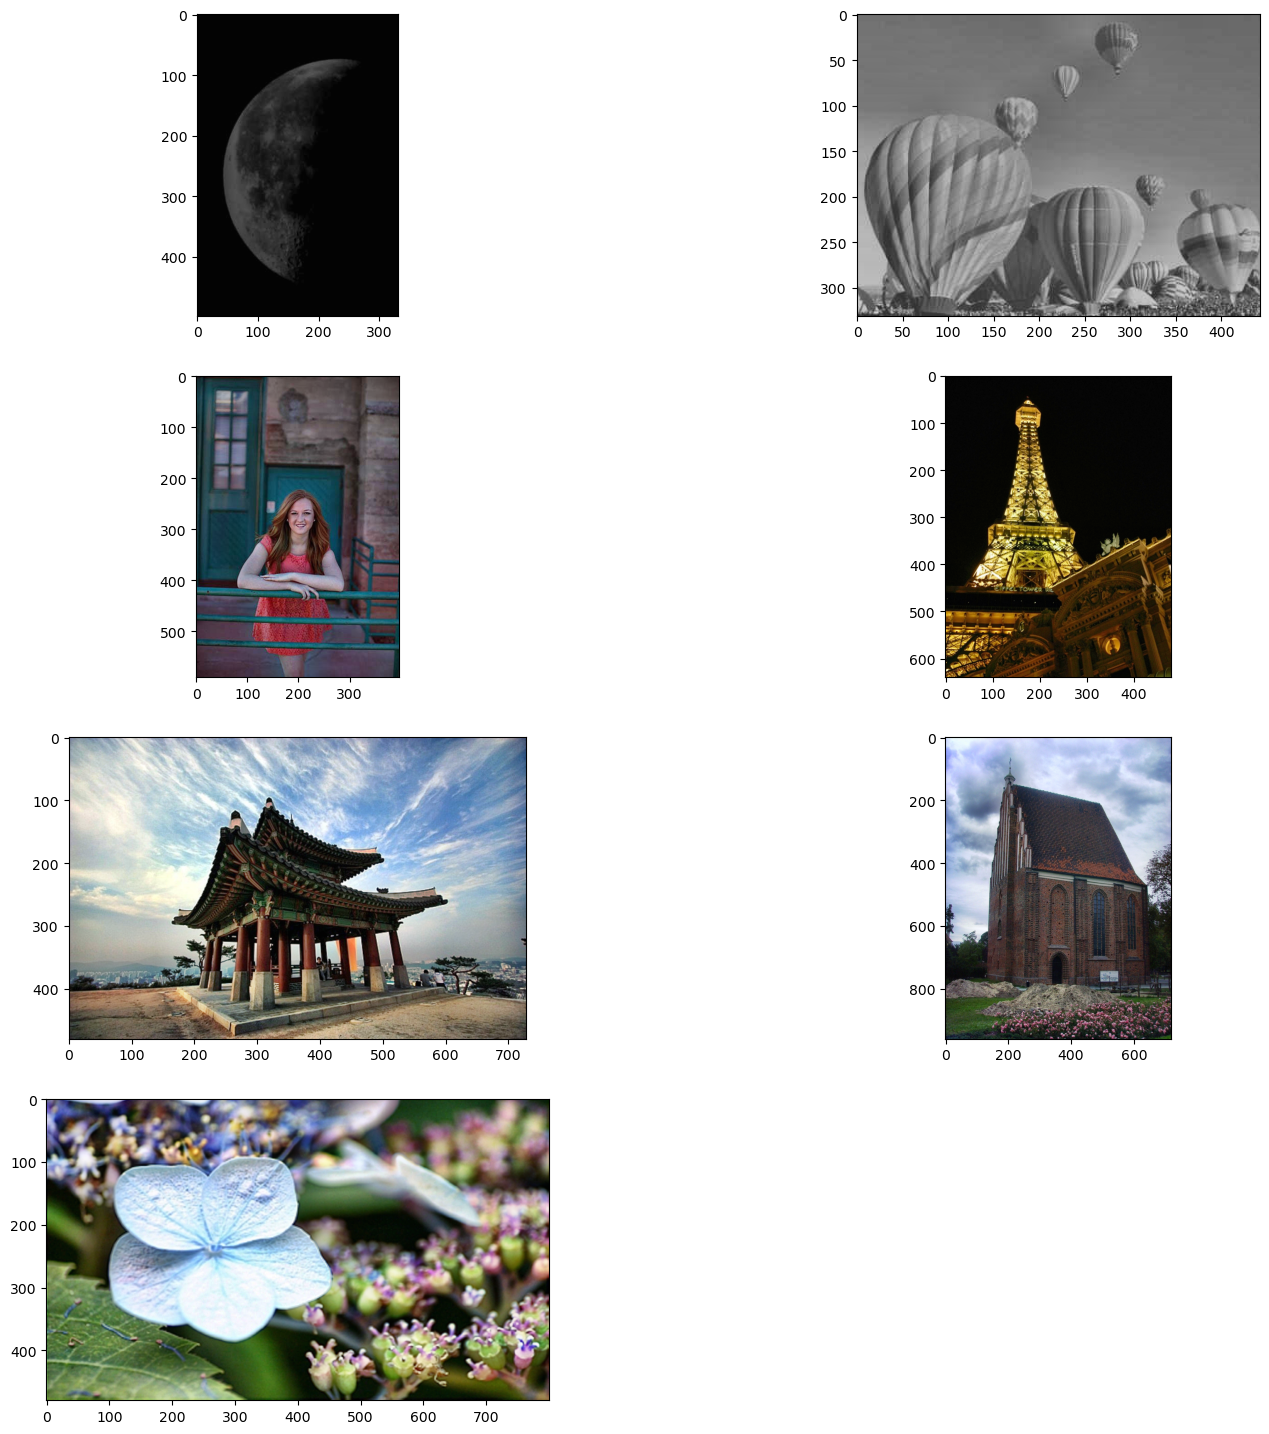

In [10]:
img_paths = glob.glob('testdata/*.jpg')
plt.figure(figsize=(18, 18))
for i, img_path in enumerate(img_paths):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = he(img)
    plt.subplot(4,2,i+1)
    plt.imshow(img)
plt.show()

# Cân bằng mức xám động

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
# import imageio
import scipy, scipy.misc, scipy.signal
import cv2
import sys
import numpy as np
import scipy.signal
import matplotlib.colors

C:\Users\ASUS\AppData\Local\Temp\ipykernel_7424\1822197113.py:5: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  import scipy, scipy.misc, scipy.signal


# Yêu cầu
Hoàn thiện hàm build_is_hist và dhe

Tài liệu tham khảo: https://www.researchgate.net/publication/3183129_A_Dynamic_Histogram_Equalization_for_Image_Contrast_Enhancement

In [ ]:
def build_is_hist(img):
    hei = img.shape[0]
    wid = img.shape[1]
    ch = img.shape[2]
    Img = np.zeros((hei + 4, wid + 4, ch))
    for i in range(ch):
        Img[:,:,i] = np.pad(img[:,:,i], (2,2), 'edge')
    hsv = (matplotlib.colors.rgb_to_hsv(Img))
    hsv[:,:,0] = hsv[:,:,0] * 255
    hsv[:,:,1] = np.sqrt(hsv[:,:,1]) * 255
    hsv[hsv>255] = 255
    hsv[hsv<0] = 0
    hsv = hsv.astype(np.uint8).astype(np.float64)
    fh = np.array([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])
    fv = fh.conj().T
    
    H = hsv[:,:,0]
    S = hsv[:,:,1]
    I = hsv[:,:,2]

    dIh = scipy.signal.convolve2d(I, np.rot90(fh, 2), mode='same')
    dIv = scipy.signal.convolve2d(I, np.rot90(fv, 2), mode='same')
    dIh[dIh==0] = 0.00001
    dIv[dIv==0] = 0.00001
    dI = np.sqrt(dIh**2+dIv**2).astype(np.uint32)
    di = dI[2:hei+2,2:wid+2]
    
    dSh = scipy.signal.convolve2d(S, np.rot90(fh, 2), mode='same')
    dSv = scipy.signal.convolve2d(S, np.rot90(fv, 2), mode='same')
    dSh[dSh==0] = 0.00001
    dSv[dSv==0] = 0.00001
    dS = np.sqrt(dSh**2 + dSv**2).astype(np.uint32)
    ds = dS[2:hei+2, 2:wid+2]

    
    h = H[2:hei+2,2:wid+2]
    s = S[2:hei+2, 2:wid+2]
    i = I[2:hei+2, 2:wid+2]
    
    Imean = scipy.signal.convolve2d(I,np.ones((5,5))/25, mode='same')
    Smean = scipy.signal.convolve2d(S,np.ones((5,5))/25, mode='same')
    
    Rho = np.zeros((hei+4,wid+4))
    for p in range(2,hei+2):
        for q in range(2,wid+2):
            tmpi = I[p-2:p+3,q-2:q+3]
            tmps = S[p-2:p+3,q-2:q+3]
            corre = np.corrcoef(tmpi.flatten('F'),tmps.flatten('F'))
            Rho[p,q] = corre[0,1]
    
    rho = np.abs(Rho[2:hei+2,2:wid+2])
    rho[np.isnan(rho)] = 0
    rd = (rho*ds).astype(np.uint32)
    Hist_I = np.zeros((256,1))
    Hist_S = np.zeros((256,1))
    
    for n in range(0,255):
        temp = np.zeros(di.shape)
        temp[i==n] = di[i==n]
        Hist_I[n+1] = np.sum(temp.flatten('F'))
        temp = np.zeros(di.shape)
        temp[i==n] = rd[i==n]
        Hist_S[n+1] = np.sum(temp.flatten('F'))
    ### YOUR CODE HERE ###
    return Hist_I, Hist_S

In [ ]:
def dhe(img, alpha=0.5):
    hist_i, hist_s = build_is_hist(img)
    hist_c = alpha*hist_s + (1-alpha)*hist_i
    hist_sum = np.sum(hist_c)
    hist_cum = hist_c.cumsum(axis=0)
    
    hsv = matplotlib.colors.rgb_to_hsv(img)
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    i = hsv[:,:,2].astype(np.uint8)
    
    c = hist_cum / hist_sum
    s_r = (c * 255)
    i_s = np.zeros(i.shape)
    for n in range(0,255):
        i_s[i==n] = s_r[n+1]/255.0
    i_s[i==255] = 1
    hsi_o = np.stack((h,s,i_s), axis=2)
    result = matplotlib.colors.hsv_to_rgb(hsi_o)
    
    result = result * 255
    result[result>255] = 255
    result[result<0] = 0
    return result.astype(np.uint8)

In [125]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def dynamic_histogram_equalization(img):
    # img = cv2.imread(img_path)  # Read the grayscale image
    # img = img[:,:,1]
    
    # plt.figure(figsize=(10, 5))
    # plt.subplot(2, 2, 1)
    # plt.imshow(img, cmap='gray')
    # plt.title("Original Image")
    
    # plt.subplot(2, 2, 2)
    # plt.hist(img.ravel(), bins=256, range=[0, 256], color='black')
    # plt.title("Original Histogram")
    
    hist, bins = np.histogram(img.flatten(), 256, [0, 256])
    pixel_start = np.min(np.where(hist > 0))
    pixel_end = np.max(np.where(hist > 0))
    
    # First partitioning
    part = partition(pixel_start, pixel_end, hist)
    
    # Iterative re-partitioning
    i, flag = 0, True
    while flag:
        i, part, flag = re_partition(hist, part, i)
    
    span = np.array([p[1] - p[0] + 1 for p in part])
    range_span = span * 255 / np.sum(span)
    
    part_span = np.zeros((len(part), 2), dtype=int)
    part_span[0, 1] = int(range_span[0])
    
    for i in range(1, len(part)):
        part_span[i, 0] = part_span[i - 1, 1]
        part_span[i, 1] = part_span[i, 0] + int(range_span[i])
    
    trans_func = get_transform_function(part, part_span, hist)
    
    # Apply transformation
    transformed_img = np.vectorize(lambda x: trans_func[x])(img)
    
    # plt.subplot(2, 2, 3)
    # plt.imshow(transformed_img, cmap='gray')
    # plt.title("DHE Processed Image")
    
    # plt.subplot(2, 2, 4)
    # plt.hist(transformed_img.ravel(), bins=256, range=[0, 256], color='black')
    # plt.title("DHE Histogram")
    
    # plt.show()
    return transformed_img

def partition(pixel_start, pixel_end, hist):
    # win_size = 1
    gap = 5
    part = [[pixel_start, None]]
    
    for i in range(pixel_start + 1, pixel_end - 1):
        if hist[i - 1] > hist[i] + gap and hist[i + 1] > hist[i] + gap:
            part[-1][1] = i - 1
            part.append([i, None])
            # part.append([i + 1 - win_size, pixel_end])
    part[-1][1] = pixel_end

    return np.array(part)

def re_partition(hist, part, i):
    flag = False
    
    mean, std, total = calculate_stats(part[i], hist)
    
    if np.isnan(mean):
        i += 1
        if i >= len(part):
            flag = False
        else:
            flag = True
    else:
        cl, cr = int(max(np.round(mean - std), 0)), int(min(np.round(mean + std) + 1, len(hist)))
        # print(cl, cr)
        region_count = np.sum(hist[cl : cr])
        if region_count / total > 0.683:
            i += 1
        else:
            # print(len(part))
            partTemp = np.zeros((len(part) + 2, 2), dtype=int)
            partTemp[:i] = part[:i]
            partTemp[i] = [part[i][0], cl]
            partTemp[i + 1] = [cl + 1, cr - 1]  # Second new partition
            partTemp[i + 2] = [cr, part[i][1]]  # Third new partition
            partTemp[i+3:] = part[i+1:]
            flag = True
    
    return i, part, flag

def get_transform_function(part, part_span, hist):
    trans_func = np.zeros(256, dtype=int)

    # for i in range(len(part)):
    #     print(part[i][0], part[i][1])
    
    for i in range(len(part)):
        pixel_range = np.arange(part[i][0], part[i][1] + 1)
        pixel_range_mapped = np.linspace(part_span[i][0], part_span[i][1], len(pixel_range), dtype=int)
        
        cdf = np.cumsum(hist[part[i][0]:part[i][1] + 1])
        # print(len(hist))
        cdf = cdf / cdf[-1]
        trans_func[pixel_range] = np.round(cdf * (part_span[i][1] - part_span[i][0]) + part_span[i][0]).astype(int)
    
    return trans_func

def calculate_stats(part, hist):
    pixels = np.arange(part[0], part[1] + 1)
    total = np.sum(hist[pixels])
    mean = np.sum(pixels * hist[pixels]) / total if total > 0 else np.nan
    std = np.sqrt(np.sum(((pixels - mean) ** 2) * hist[pixels]) / total) if total > 0 else np.nan
    return mean, std, total


KeyboardInterrupt: 

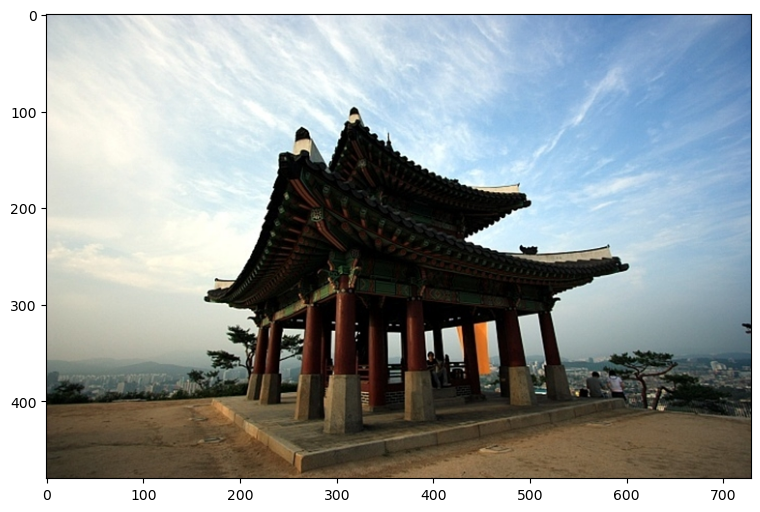

In [ ]:
img = cv2.imread('testdata/z02.jpg')
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
img[:,:,0] = dynamic_histogram_equalization(img[:,:,0])
img[:,:,1] = dynamic_histogram_equalization(img[:,:,1])
img[:,:,2] = dynamic_histogram_equalization(img[:,:,2])
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# https://github.com/wsss-ustc/Histogram-Equalization/blob/master/A%20dynamic%20histogram%20equalization%20for%20image%20contrast%20enhancement.pdf
# new_img = dynamic_histogram_equalization('testdata/0moon_dark.jpg')

In [43]:
def dnc(hist, l, r):
    if l >= r:
        return []
    arr = []
    for i in range(l, r + 1):
        for _ in range(hist[i]):
            arr.append(i)
    if len(arr) == 0:
        return []
    mean = np.mean(arr, dtype = np.float64)
    std = np.std(arr, dtype = np.float64)
    # print(l, r, mean, std)
    ap = 0
    nl = int(np.ceil(mean - std))
    nr = int(np.floor(mean + std))
    for i in range(nl, nr + 1):
        ap += hist[i]
    res = [nl - 1, nr]
    if ap / np.sum(arr) < 0.683:
        res += dnc(hist, l, nl - 1)
        res += dnc(hist, nr + 1, r)
    return res

In [77]:
def dhe(hist, x = 0.5):
    m = []
    for i in range(len(hist)):
        if hist[i] != 0:
            m.append(i)
            break
    for i in range(1, len(hist) - 1):
        if hist[i] > hist[i - 1] and hist[i] > hist[i + 1]:
            m.append(i)
    for i in range(len(hist) - 1, -1, -1):
        if hist[i] != 0:
            m.append(i)
            break
    nm = []
    for i in range(0, len(m) - 1):
        nm += dnc(hist, m[i] + (i != 0), m[i + 1])
    nm.sort()

    m = [nm[0]]
    for i in range(1, len(nm)):
        if nm[i] != nm[i - 1]:
            m.append(nm[i])
    
    factor = []
    for i in range(1, len(nm)):
        cl = nm[i - 1] + (i != 0)
        cr = nm[i]
        span = cr - cl + 1
        sum = 0
        for j in range(cl, cr + 1):
            sum += j * hist[j]
        factor.append(span * np.log(sum))
    

    print(len(hist), len(m))
    print(m)

256 69
[0, 3, 5, 6, 8, 10, 12, 13, 14, 17, 19, 20, 24, 26, 27, 28, 33, 35, 37, 39, 41, 42, 48, 49, 50, 51, 52, 56, 57, 58, 59, 60, 62, 63, 65, 74, 75, 80, 81, 82, 83, 84, 86, 88, 90, 91, 92, 93, 94, 95, 97, 98, 100, 107, 108, 112, 114, 115, 116, 117, 119, 123, 124, 125, 126, 127, 130, 131, 132]


C:\Users\ASUS\AppData\Local\Temp\ipykernel_7424\851414700.py:32: RuntimeWarning: divide by zero encountered in log
  factor.append(span * np.log(sum))
C:\Users\ASUS\AppData\Local\Temp\ipykernel_7424\851414700.py:32: RuntimeWarning: invalid value encountered in scalar multiply
  factor.append(span * np.log(sum))


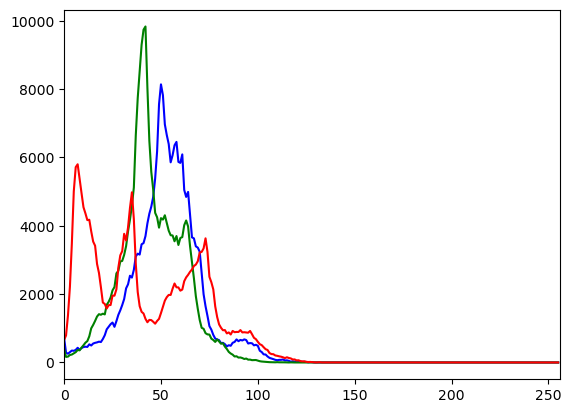

In [76]:
import matplotlib.pyplot

img = cv2.imread('testdata/girl1_dark.jpg')
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    # print(np.array(histr, dtype=np.uint16))
    plt.plot(histr, color = col)
    plt.xlim([0,256])

occ = np.zeros(256, dtype=np.uint32)
for x in img[:,:,0].ravel():
    occ[x] += 1
dhe(occ)

In [78]:
### YOUR CODE HERE ###
np.seterr(divide='ignore', invalid='ignore')
img_names = os.listdir('testdata/')
plt.figure(figsize=(18, 18)) 
for i, img_name in enumerate(img_names):
    print(i, img_name)
    img = cv2.imread(os.path.join('testdata/', img_name))
    result = dhe(img)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB) # for showing purpose
    plt.subplot(4,2,i+1)
    plt.imshow(result)
plt.show()
### YOUR CODE HERE ###

0 0moon_dark.jpg


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<Figure size 1800x1800 with 0 Axes>